In [1115]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats

In [1675]:
numcities = 50
x = np.random.random((numcities))
y = np.random.random((numcities))
xy = np.vstack([x,y]).T

In [294]:
def fitness(xy):
    total = 0
    prev = xy[0,:]
    for p in xy[1:,:]:
        total += np.sqrt((p[0] - prev[0]) ** 2 + (p[0] - prev[1]) ** 2)
        prev = p
    return total

fitness: 26.3023237393


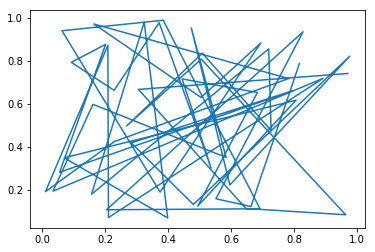

In [1676]:
plt.plot(x,y)
print('fitness:', fitness(xy))

In [1561]:
popsize = 200
pop = [np.random.permutation(xy.shape[0]) for i in range(popsize)]

(50, 2)


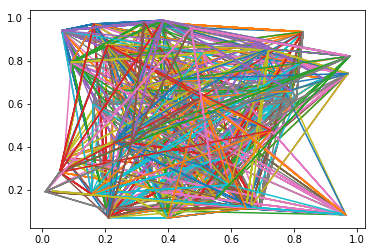

In [1677]:
#print([fitness(xy[p,:]) for p in pop])
#print(xy[pop,0], xy[pop,1])
print(xy.shape)
popmat = np.array(pop)
plt.plot(xy[popmat,0], xy[popmat,1]);

In [548]:
def weighted_choice(choices):
    '''
    Returns a randomly chosen item in the list considering the weights.
    Unlike numpy.random.choice, this function is not capable of returning multiple items with a single invocation.

    Parameters
    ----------
    choices
        a list of tuples (c, w) where c is the item to be returned and w is the weight of the parameter.

    Returns
    -------
    type(choices[0])
        the chosen item.
    '''
    total = sum(w for c, w in choices)
    r = np.random.uniform(0, total)
    upto = 0
    for i in range(len(choices)):
        c, w = choices[i][0], choices[i][1]
        if upto + w >= r:
            return weighted_choice.Result(c, i)
        upto += w
    assert False, "Shouldn't get here"
from collections import namedtuple
weighted_choice.Result = namedtuple('Result', ['chosen', 'idx'])

We introduce a metric of diversity by measuring other individuals who have the same city id at the same index.
And we combine the fitness rank $F_i$ and diversity rank $D_i$ by multiplying probability mass.

$$
P_i(F_i, D_i) = {P_c}^{F_i + D_i}
$$

In [1627]:
def select(pop):
    # Truncate elements which are less fit than half of all the elements
    # to pass the genes down to the next generation.
    pc = 0.5
    nextpop = 195
    elitepop = 5
    popmean = np.mean(pop,0)
    popstd = np.std(pop,0)
    popstd[popstd == 0] = 1e-10
    fitvals = 1 / np.array([fitness(xy[p,:]) for p in pop])
    fitness_order = np.argsort(1 / fitvals)
    fitlist = [pop[i] for i in fitness_order]
    values = fitlist[:elitepop]
    #print(len(values))
    non_elites = fitlist[elitepop:]
    fitvals = fitvals[fitness_order][elitepop:]
    #print(len(non_elites))
    prob = pc ** np.arange(len(non_elites))
    for i in range(nextpop):
        chosen, idx = weighted_choice([(non_elites[i], prob[i]) for i in range(len(non_elites))])
        values.append(chosen)
        del non_elites[idx]
        fitvals = np.delete(fitvals, idx)
        popmean = np.mean(values,0)
        popstd = np.std(values,0)
        popstd[popstd == 0] = 1e-10
        #goodness = 1 / (fitvals + 1e-22 / np.exp(-((non_elites - popmean) / popstd) ** 2).prod(1))
        goodness = 1 / (np.array([1 / np.sum(values == p) for p in non_elites]))
        #goodness = 1 / fitvals
        prob = pc ** (np.argsort(fitvals) + np.argsort(goodness))
        #prob = np.delete(prob, idx)
    #values = sorted(pop, key=lambda p: fitness(xy[p,:]))[:popsize//2]
    #print([(non_elites[i], prob[i]) for i in range(len(non_elites))])
    return values

## Visualize diversity of the population

We use standard deviation to have a rough idea of how the population is diverse.
It doesn't really make sense since class numbers are not in Euclidian space, but it's fast to calculate.
We should count sequence of cities in the same order in the population, but it's very computationally expensive.

[200 196   6   6   6   6   6   6   6   6   6   6   7   8   7   6   9   8
   6   6  82   5   5   5   5   5   5 182   8   5   5   6   6   8   6   6
   6   6   6   7   6   6   6   8   6   6   6   7 198 200] 1331
200 (200, 50)


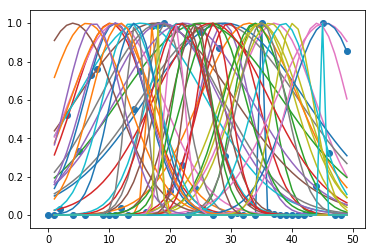

In [1678]:
popmean = np.mean(pop,0)
popstd = np.std(pop,0)
popstd[popstd == 0] = 1e-10
popmask = np.sum(pop==pop[0],0)
print(popmask, sum(popmask))
#print('popmean[{}]'.format(popmean.shape), popmean, '\npopstd[{}]'.format(popstd.shape), popstd)
print(len(pop), ((pop) - popmean).shape)
x = np.arange(1,len(xy))
plt.plot(x, np.exp(-((x.reshape((-1,1)) - popmean.reshape((1,-1))) / popstd.reshape((1,-1))) ** 2))
plt.scatter(pop[0], np.exp(-((pop[0] - popmean) / popstd) ** 2))
def diversity(p):
    #return (1 / np.exp(-((p - popmean) / popstd) ** 2).prod(1))
    return 1 / np.sum(pop==p)
#plt.figure()
#print(diversity(pop[0]))
#plt.plot(np.array([[fitness(xy[p,:]) for p in pop], 1e3 * np.array([diversity(p) for p in pop])]).T)
#print(np.array([fitness(xy[p,:]) for p in pop]).shape)
#print((1 / np.array([fitness(xy[p,:]) for p in pop]) + 1 / np.exp(-((pop - popmean) / popstd) ** 2).prod(1)))

In [1141]:

def mutate(pop,temperature):
    total_mutations = 0
    for ti in range(len(pop)):
        mutation_num = np.random.poisson(temperature * 0.1)
        if mutation_num < 1:
            continue
        total_mutations += mutation_num
        for i in range(mutation_num):
            p = pop[ti]
            first = int(np.random.random() * xy.shape[0])

            # Weights based on spatial distance
            #scores = [(v, np.exp(-sum((xy[p[first],:] - xy[v,:]) ** 2) / temperature ** 2)) if v != p[first] else (p[first], 0) for v in p]

            # Weights based on distance of order 
            scores = [(v, np.exp(-((p[first] - v) ** 2) / temperature ** 2)) if v != p[first] else (p[first], 0) for v in p]

            elems = sorted(p[np.random.permutation(len(p))[:2]])
            #print(ti, elems)
            p[elems[0]:elems[1]] = p[elems[0]:elems[1]][::-1]
            pop[ti] = p
            #second = weighted_choice(scores).chosen
            #swapelems = np.random.permutation(xy.shape[0])[:2]
            #print(swapelems)
            #print('p', p)
            #tmp = p[swapelems[0]]
            #p[swapelems[0]] = p[swapelems[1]]
            #p[swapelems[1]] = tmp
            #print('p', p)
            #p[first], p[second] = p[second], p[first]
    return pop, total_mutations

In [1103]:
nextpop = mutate(pop, 1)

In [1523]:
def crossover(pop):
    crossover_num = 250
    for i in range(crossover_num):
        crosselem = np.random.permutation(len(pop))[:2]
        p0, p1 = pop[crosselem[0]], pop[crosselem[1]]
        if True:
            def crossover_elem(p0, p1):
                order = []
                dir = np.random.random() < 0.5
                for i in range(pivot,len(p0)) if dir else range(0,pivot):
                    order.append(np.argwhere(p1 == p0[i])[0][0])
                return np.hstack([p0[:pivot], p1[sorted(order)]]) if dir else np.hstack([p1[sorted(order)], p0[pivot:]])
            pivot = np.random.choice(len(p0))
            pop.append(crossover_elem(p0, p1))
            if len(pop) < popsize:
                pop.append(crossover_elem(p1, p0))
        else:
            #print('crosselem', crosselem, 'p0', len(p0), p0, 'p1', len(p0), p1)
            #print(sorted(p0), sorted(p1))
            crossmask = np.random.random(p0.shape) < 0.5
            #print('crossmask', len(crossmask), sum(crossmask), crossmask)
            crossnums = p0[crossmask]
            #print('crossnums', crossnums)
            crossmask1 = np.array([i in crossnums for i in p1], dtype=bool)
            #print('crossmask1', len(crossmask1), sum(crossmask1), crossmask1)
            #tmp = p0[crossmask]
            #print(len(tmp), len( p1[crossmask1]), tmp)
            #p0[crossmask] = p1[crossmask1]
            #p1[crossmask1] = tmp
            newindiv = p0
            newindiv[crossmask] = p1[crossmask1]
            pop.append(newindiv)
            if len(pop) < popsize:
                newindiv = p1
                newindiv[crossmask1] = p0[crossmask]
        #p0[crossmask], p1[crossmask1] = p1[crossmask1], p0[crossmask]
    return pop


In [1681]:
nextpop = select(crossover(pop))
print(len(nextpop), nextpop[-1], sorted(nextpop[-1]))

200 [35 17 34  5 30  0 47 44 43 28  8 24  4 32 39 26 11  2 38 16  7 15 31 42 33
 22 49 19 37 12 48  3 29 20  9  1 46 36 41 40 13 10 23 27  6 25 21 14 18 45] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [1682]:
bestfit = 1e5
bestelem = None
fit_hist = []
best_hist = []
mutation_hist = []
temperature = 1.

In [ ]:
epoch = 1000

for i in range(epoch):
    try:
        fitlist = [fitness(xy[p,:]) for p in pop]
        fit = sum(fitlist) / len(pop)
        thisbestfit = np.argmin(fitlist)
        if fitlist[thisbestfit] < bestfit:
            bestfit = fitlist[thisbestfit]
            bestelem = pop[0].copy()
        fit_hist.append(fit)
        best_hist.append(bestfit)
        pop, mutation_num = mutate(pop, temperature)
        mutation_hist.append(mutation_num if len(mutation_hist) == 0 else mutation_hist[-1] + mutation_num)
        if i % 10 == 0:
            print('iter', i, ', fitness: ', fit, ', temperature: ', temperature, ', mutations: ', mutation_hist[-1])
        #temperature *= .9999
        pop = crossover(pop)
        pop = select(pop)
    except KeyboardInterrupt:
        print('interrupted')
        break

iter 0 , fitness:  25.167392196 , temperature:  1.0 , mutations:  52
iter 10 , fitness:  29.5355139532 , temperature:  1.0 , mutations:  258


27.7839729577 11.5061723609


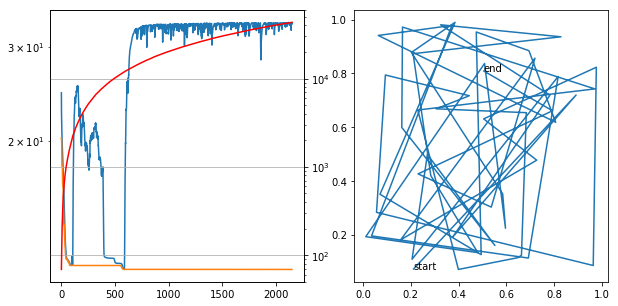

In [1679]:
print(fitness(xy[pop[0],:]), bestfit)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].semilogy(np.array([fit_hist, best_hist]).T)
ax2 = ax[0].twinx()
ax2.semilogy(mutation_hist, 'r')
ax2.grid()
ax[1].plot(xy[bestelem,0], xy[bestelem,1]);
ax[1].text(xy[bestelem[0],0],xy[bestelem[0],1],'start')
ax[1].text(xy[bestelem[-1],0],xy[bestelem[-1],1],'end')